In [1]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [2]:
# Read your CSV of in-session bars + signals
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True)

# Collect each day’s feature-engineered frame
frames = []
for day, day_df in df_sign.groupby(df_sign.index.normalize()):
    # day_df has only that session’s bars
    feats = models.feature_engineering(day_df, params.feats_cols_all, params.label_col)
    frames.append(feats)

# Re-assemble back into one long DF
df_raw = pd.concat(frames).sort_index()

# (Optional) drop bid/ask 
df_raw_drop = df_raw.drop(['bid','ask'], axis=1)
df_raw_drop

,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,atr_14,vwap_dev,rsi_14,bb_width_20,stoch_k_14,stoch_d_3,ma_5,ma_20,ma_diff,macd_12_26,macd_signal_9,obv,in_trading,hour,day_of_week,month,signal
2004-01-02 13:09:00,0.764235,0.764235,0.764235,0.764235,48081.25,-0.000022,-0.000066,-0.000066,0.000009,1.567313,0.000004,-0.000065,0.000000,0.000070,0.000000,0.000000,0.764266,0.764281,-0.000015,-0.000007,-0.000002,-124162.50,0,13,4,1,0.077619
2004-01-02 13:10:00,0.764219,0.764219,0.764219,0.764219,54775.00,-0.000022,-0.000088,-0.000088,0.000010,1.687332,0.000005,-0.000086,0.000000,0.000101,0.000000,0.000000,0.764252,0.764277,-0.000025,-0.000011,-0.000004,-178937.50,0,13,4,1,0.082208
2004-01-02 13:11:00,0.764202,0.764202,0.764202,0.764202,61468.75,-0.000022,-0.000110,-0.000110,0.000011,1.771753,0.000006,-0.000107,0.000000,0.000133,0.000000,0.000000,0.764235,0.764273,-0.000038,-0.000015,-0.000006,-240406.25,0,13,4,1,0.087074
2004-01-02 13:12:00,0.764185,0.764185,0.764185,0.764185,68162.50,-0.000022,-0.000110,-0.000131,0.000011,1.823929,0.000007,-0.000128,0.000000,0.000167,0.000000,0.000000,0.764219,0.764268,-0.000049,-0.000019,-0.000009,-308568.75,0,13,4,1,0.092235
2004-01-02 13:13:00,0.764169,0.764169,0.764169,0.764169,74856.25,-0.000022,-0.000110,-0.000153,0.000011,1.848531,0.000008,-0.000148,0.000000,0.000202,0.000000,0.000000,0.764202,0.764262,-0.000060,-0.000024,-0.000012,-383425.00,0,13,4,1,0.097706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.00,0.000635,0.002846,0.003639,0.000804,1.703441,0.276029,0.002191,69.675681,0.004172,72.169811,62.051653,196.593000,196.325795,0.267205,0.175662,0.134526,3773131.00,1,20,2,6,0.417935
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.00,-0.000712,0.001450,0.003081,0.000836,1.841981,0.291029,0.001453,62.080501,0.004427,58.567483,64.412431,196.650000,196.348545,0.301455,0.179462,0.143513,3312501.00,1,20,2,6,0.368513
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.00,-0.000025,0.000559,0.002291,0.000823,1.883214,0.291743,0.001403,60.449896,0.004636,58.091247,62.942847,196.672000,196.369045,0.302955,0.179996,0.150810,2787256.00,1,20,2,6,0.365417
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.00,-0.002189,-0.001375,-0.000255,0.001017,5.053932,0.313971,-0.000791,51.403049,0.004652,17.134965,44.597898,196.618000,196.367545,0.250455,0.144060,0.149460,711753.00,1,20,2,6,0.280949


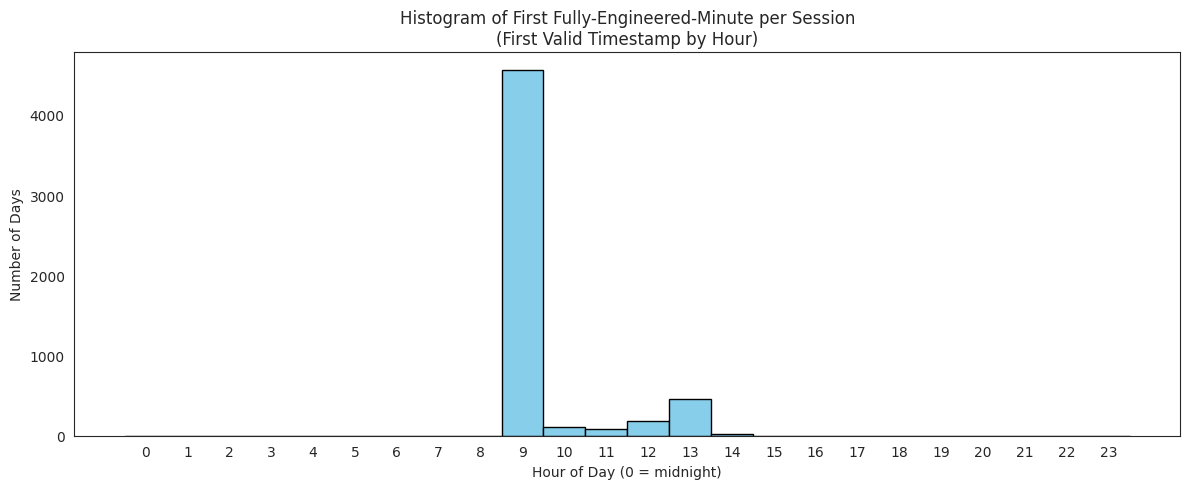

In [3]:
# NB some features like RSI and stochastic oscillators stay NaN until there’s enough nonzero price variation in their rolling windows
# so in the flat-morning data they only “wake up” when movement finally appear, and it could be even around 13.00

# 1. Compute first valid timestamp per day
first_valid = (
    df_raw_drop
      .groupby(df_raw_drop.index.normalize())
      .apply(lambda grp: grp.dropna(subset=params.feats_cols_all).index.min())
)

# 2. Extract the hour (0–23) of each first-valid timestamp
first_valid_hours = first_valid.dt.hour

# 3. Plot histogram with one bin per hour
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),          # 24 one-hour bins from 0 to 24
    align='left',               # bin i covers [i, i+1)
    color='skyblue',
    edgecolor='black'
)

# 4. Format axes and labels
plt.xticks(range(0, 24))        # tick at each hour
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Engineered-Minute per Session\n(First Valid Timestamp by Hour)')
plt.tight_layout()
plt.show()


In [14]:
# feed the trimmed DataFrame into the existing call
df_feat_all = models.scale_with_splits(
    df           = df_raw,
    features_cols= params.feats_cols_all,
    label_col    = params.label_col,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
df_feat_drop = df_feat_all.drop(['bid','ask'], axis=1)
df_feat_drop

Scaling price per day (train):   0%|          | 0/3859 [00:00<?, ?day/s]

Scaling price per day (val):   0%|          | 0/773 [00:00<?, ?day/s]

Scaling price per day (test):   0%|          | 0/770 [00:00<?, ?day/s]

saving df …


,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,macd_signal_9,obv,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bb_width_20,stoch_k_14,stoch_d_3,in_trading,hour,day_of_week,month,signal
2004-01-02 13:09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029212,-0.040971,-0.025534,-0.966783,0.534945,-0.032030,-1.995735,-0.929333,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.077619
2004-01-02 13:10:00,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.029213,-0.054390,-0.033477,-0.965007,0.667154,-0.036171,-1.995735,-0.921566,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.082208
2004-01-02 13:11:00,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.111111,-1.111111,-1.111111,-1.052039,-1.126489,-1.057584,-0.029214,-0.067809,-0.041420,-0.963779,0.760151,-0.040262,-1.995735,-0.913246,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.087074
2004-01-02 13:12:00,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.034483,-1.133333,-1.000000,-1.049817,-1.140271,-1.072598,-0.029214,-0.067810,-0.049363,-0.963001,0.817626,-0.044296,-1.995735,-0.904541,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.092235
2004-01-02 13:13:00,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.181818,-0.931034,-1.051188,-1.173995,-1.103274,-0.029215,-0.067812,-0.057307,-0.962622,0.844727,-0.048268,-1.995735,-0.895592,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.097706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.489516,0.721311,0.499698,0.701909,5.506068,2.101234,0.369500,-0.132433,2.223547,1.966827,1.575116,0.844269,0.837991,1.742521,1.317936,0.507307,0.684900,0.407906,0.750521,0.122381,0.619888,0.342752,1,-0.939,0.039,0.146,0.417935
2025-06-18 20:57:00,0.693548,0.852459,0.386941,0.474582,6.659256,2.263666,0.463607,-0.095682,2.493019,2.007157,1.663579,0.649629,-0.939239,0.887590,1.115397,0.566581,0.837512,0.263954,0.451158,0.187641,0.223810,0.415204,1,-0.939,0.039,0.146,0.368513
2025-06-18 20:58:00,0.475806,0.516393,0.495868,0.467817,7.654339,2.242849,0.499492,-0.061664,2.500419,2.010664,1.734582,0.429539,-0.033854,0.341995,0.828890,0.542508,0.882934,0.254269,0.386888,0.241322,0.209943,0.370103,1,-0.939,0.039,0.146,0.365417
2025-06-18 20:59:00,0.483871,0.524590,-0.129032,-0.226464,31.660209,2.504253,0.410684,-0.063324,2.067435,1.616873,1.714352,-0.435378,-2.888426,-0.842944,-0.094079,0.903328,4.375721,-0.173638,0.030308,0.245429,-0.982637,-0.192907,1,-0.939,0.039,0.146,0.280949


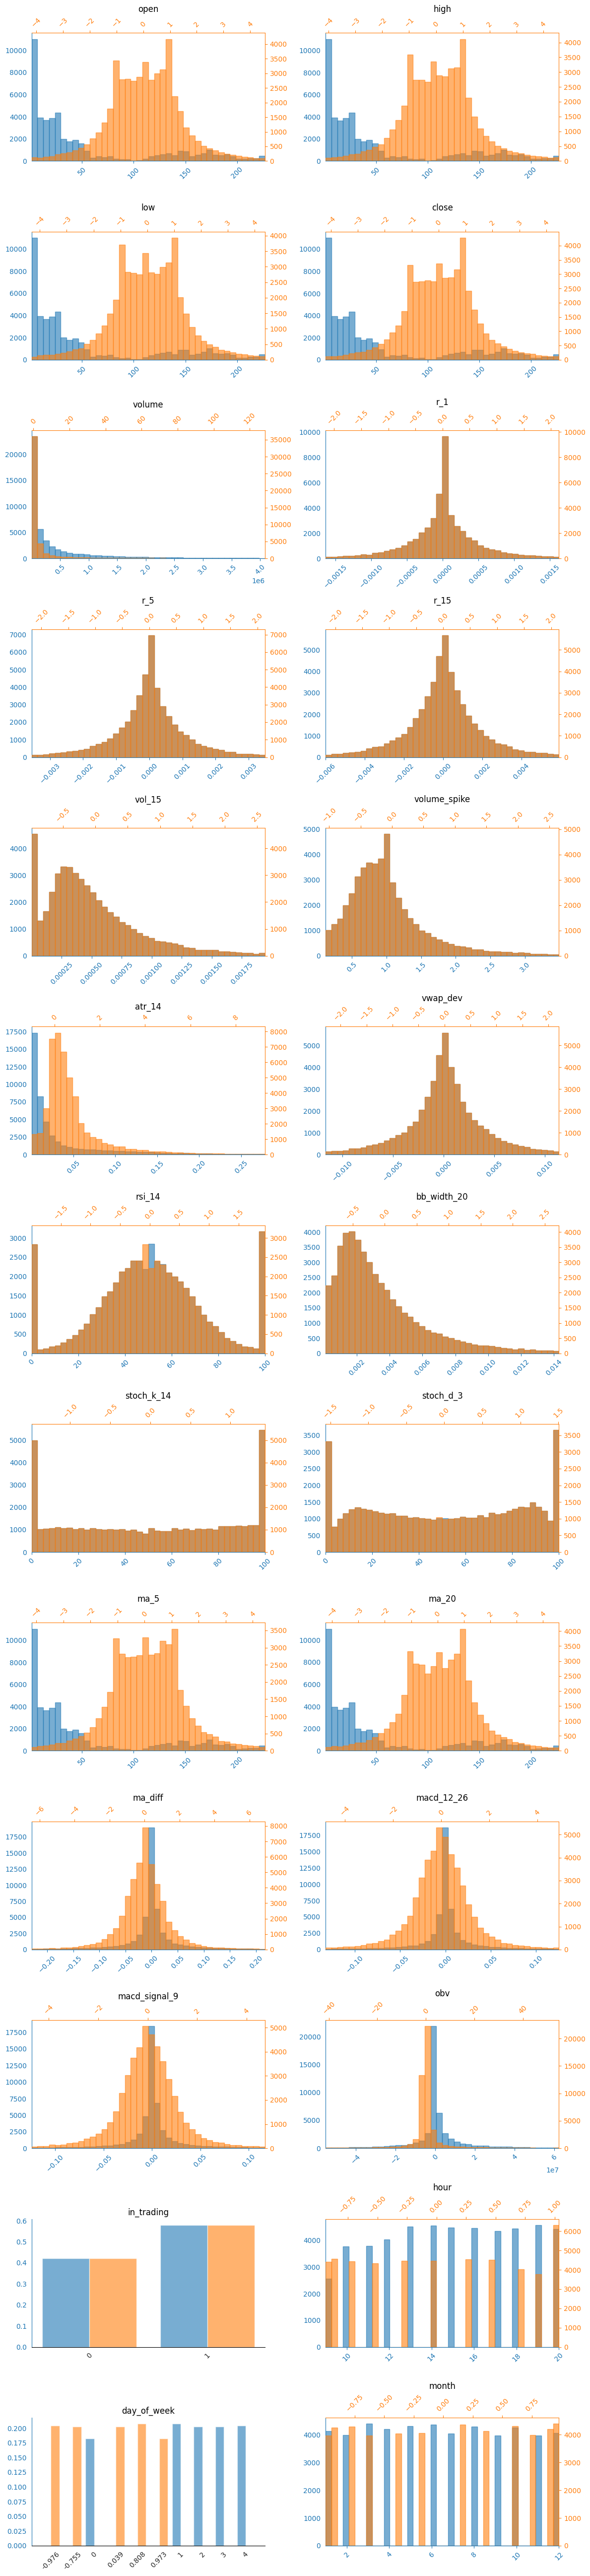

In [15]:
plots.plot_dual_histograms(
    df_before = df_raw_drop,
    df_after  = df_feat_drop,
    features  = params.feats_cols_all
)